In [696]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle
%matplotlib inline

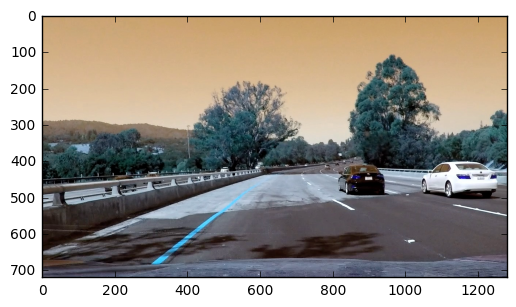

In [825]:
image = cv2.imread('./test_images/test4.jpg')
image = cv2.GaussianBlur(image, (3, 3), 0)
plt.imshow(image)

In [826]:
def calibrate():
    chessboard_list = os.listdir("./camera_cal")
    nx = 9
    ny = 6

    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    for chessboard in chessboard_list:

        img = cv2.imread("./camera_cal/" + chessboard)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    calibration_parameters = {}
    calibration_parameters["mtx"] = mtx
    calibration_parameters["dist"] = dist
    pickle.dump(calibration_parameters, open("calibration.p", "wb"))
    return mtx, dist

In [827]:
def undistort(image, mtx, dist):
    undist = cv2.undistort(image, mtx,
                            dist, None,
                            mtx)
    return undist

In [828]:
def perspective_transform(image, source_points, destination_points):
    M = cv2.getPerspectiveTransform(source_points, destination_points)
    Minv = cv2.getPerspectiveTransform(destination_points, source_points)
    warped = cv2.warpPerspective(image, M, (1280, 720), flags=cv2.INTER_LINEAR)

    return warped, Minv

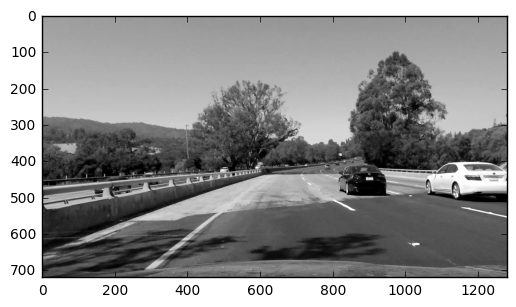

In [829]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

mtx, dist = calibrate()

gray = undistort(gray, mtx, dist)

plt.imshow(gray, cmap='gray')

In [830]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled)
    grad_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    magnitude = np.sqrt(sobelx**2 +  sobely**2)
    scaled = np.uint8(255*magnitude/np.max(magnitude))
    mag_binary = np.zeros_like(scaled)
    mag_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return mag_binary

def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

def color_thresh(image, thresh=(0, 255)):
    color_binary = np.zeros_like(image)
    color_binary[(image >= thresh[0]) & (image <= thresh[1])] = 1
    return color_binary

In [831]:
# plt.imshow(abs_sobel_thresh(gray, 'x', 7, (20, 110)), cmap='gray')

In [832]:
# plt.imshow(abs_sobel_thresh(gray, 'y', 9, (20, 110)), cmap='gray')

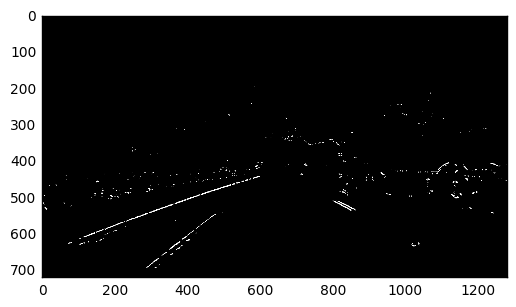

In [833]:
mag_binary = mag_thresh(gray, 9, (100, 255))
dir_binary = dir_thresh(gray, 9,  (0.6, 1.3))

combined_grad = np.zeros_like(mag_binary)
combined_grad[(mag_binary == 1) & (dir_binary == 1)] = 1
plt.imshow(combined_grad, cmap='gray')

In [834]:
hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

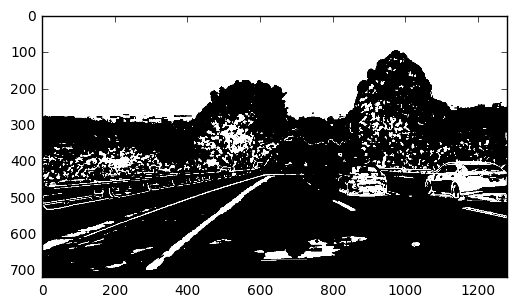

In [835]:
color_binary = color_thresh(undistort(hls_image[:,:,2], mtx, dist), (100, 255))

combined_all = np.zeros_like(color_binary)
combined_all[(color_binary == 1) | (mag_binary == 1)] = 1
plt.imshow(combined_all, cmap='gray')

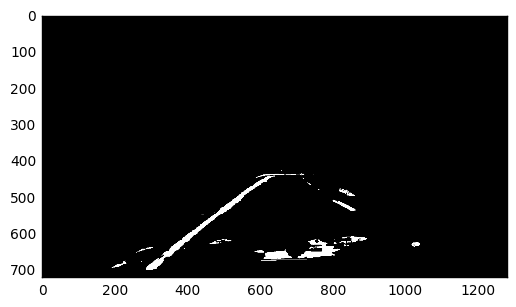

In [836]:
# Masking
mask = np.zeros_like(combined_all)
vertices = np.array([[(630, 420), (150, 720), (1180, 720), (750, 420)]], dtype=np.int32)
cv2.fillPoly(mask, vertices, (255))
c = cv2.bitwise_and(combined_all, mask)

plt.imshow(c, cmap='gray')

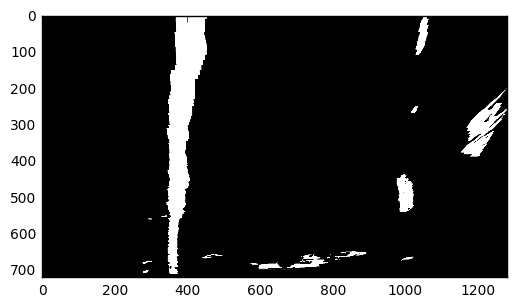

In [837]:
source_points = np.float32([[578, 460], [210, 720], [1128, 720], [710, 460]])
destination_points = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])

warped, _ = perspective_transform(c, source_points, destination_points)
plt.imshow(warped, cmap='gray')